In [ ]:
!pip install pfhedge

### Last time

In [ ]:
import pfhedge
import torch
from torch.utils.data import Dataset, DataLoader

from pfhedge.instruments import BrownianStock
from pfhedge.instruments import EuropeanOption
from pfhedge.nn import MultiLayerPerceptron

stock = BrownianStock(cost=0.001)
derivative = EuropeanOption(stock, strike=1.0)
m = MultiLayerPerceptron(3)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = torch.stack(data, dim=-1)

    def __len__(self):
        return self.data.size(1)

    def __getitem__(self, index):
        return self.data[:, index, :].unsqueeze(1)

torch.manual_seed(42)

derivative.simulate(2000)
lm = derivative.moneyness()
t = derivative.time_to_maturity()
v = derivative.ul().volatility

ds = MyDataset([lm, t, v])

In [ ]:
class MLP(torch.nn.Module):

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        output = self.model(x)
        return output

In [ ]:
mm = MLP(m)
mm

MLP(
  (model): MultiLayerPerceptron(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Identity()
  )
)

In [ ]:
for i in mm.parameters():
    print(i)

In [ ]:
sum(p.numel() for p in mm.parameters())

3329

### compute_hedge

In [ ]:
def compute_hedge(model, ds):
    outputs = []
    for i in ds:
        out = model(i)
        outputs.append(out)

    return torch.cat(outputs, dim=-1)

In [ ]:
compute_hedge(mm, ds)

tensor([[[-0.0679, -0.0679, -0.0679,  ..., -0.0673, -0.0673, -0.0672]],

        [[-0.0679, -0.0678, -0.0679,  ..., -0.0677, -0.0676, -0.0676]],

        [[-0.0679, -0.0679, -0.0679,  ..., -0.0673, -0.0673, -0.0672]],

        ...,

        [[-0.0679, -0.0678, -0.0678,  ..., -0.0677, -0.0677, -0.0677]],

        [[-0.0679, -0.0678, -0.0678,  ..., -0.0676, -0.0676, -0.0676]],

        [[-0.0679, -0.0679, -0.0679,  ..., -0.0674, -0.0673, -0.0673]]],
       grad_fn=<CatBackward0>)

### compute_portfolio

In [ ]:
def compute_portfolio(model, ds, derivative):

    spot = torch.stack([derivative.ul().spot], dim=1)
    unit = compute_hedge(model, ds)

    return pfhedge.nn.functional.pl(spot, unit)

In [ ]:
compute_portfolio(mm, ds, derivative)

tensor([ 0.0030, -0.0048,  0.0030,  ..., -0.0059, -0.0048,  0.0013],
       grad_fn=<SumBackward1>)

In [ ]:
def compute_portfolio_2(model, ds, derivative):

    spot = torch.stack([derivative.ul().spot], dim=1)
    unit = compute_hedge(model, ds)

    return pfhedge.nn.functional.pl(spot, unit, payoff=derivative.payoff())

In [ ]:
compute_portfolio_2(mm, ds, derivative)

tensor([ 0.0030, -0.0754,  0.0030,  ..., -0.0932, -0.0758,  0.0013],
       grad_fn=<SubBackward0>)

### fit()

In [ ]:
def fit(model, ds, derivative):

    optimizer = torch.optim.Adam(model.parameters())

    for i in range(1000):
        optimizer.zero_grad()
        cash = compute_portfolio_2(model, ds, derivative)
        # loss = torch.sum(cash*cash)
        loss = pfhedge.nn.functional.entropic_risk_measure(cash)
        #loss = pfhedge.nn.functional.expected_shortfall(cash, 0.8)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(loss)



In [ ]:
fit(mm, ds, derivative)

tensor(0.0228, grad_fn=<DivBackward0>)
tensor(0.0226, grad_fn=<DivBackward0>)
tensor(0.0221, grad_fn=<DivBackward0>)
tensor(0.0212, grad_fn=<DivBackward0>)
tensor(0.0203, grad_fn=<DivBackward0>)
tensor(0.0199, grad_fn=<DivBackward0>)
tensor(0.0194, grad_fn=<DivBackward0>)
tensor(0.0189, grad_fn=<DivBackward0>)
tensor(0.0182, grad_fn=<DivBackward0>)
tensor(0.0173, grad_fn=<DivBackward0>)


### How good is it?

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
temp = compute_hedge(mm, ds)
temp.size()

torch.Size([2000, 1, 21])

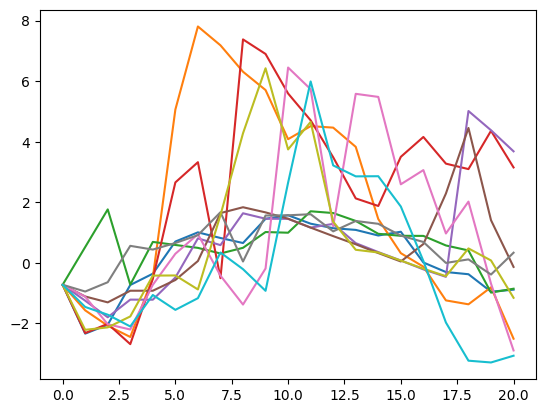

In [ ]:
plt.plot(temp.squeeze(1).detach().numpy()[0:10].T)
#plt.ylim(-1,1)
plt.show()

In [ ]:
temp_2 = compute_portfolio_2(mm, ds, derivative)
temp_2.size()

torch.Size([2000])

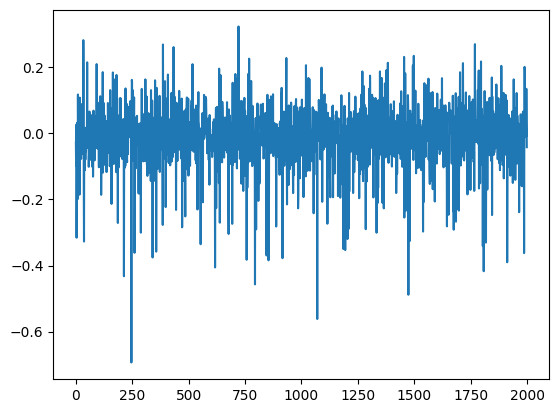

In [ ]:
plt.plot(temp_2.detach().numpy())
#plt.ylim(-0.1, 0.1)
plt.show()

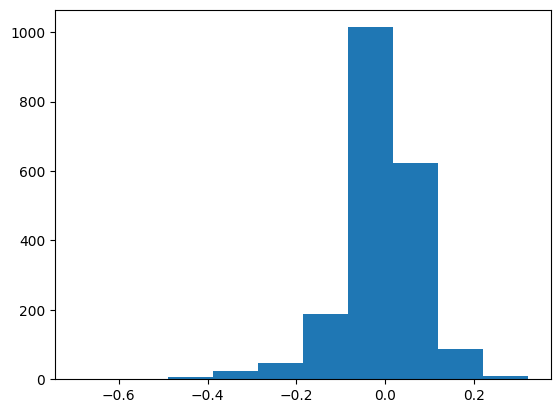

In [ ]:
plt.hist(temp_2.detach().numpy())
#plt.xlim(-0.1, 0.1)
plt.show()